I've always been interested in how machine learning can apply to visual arts. In particular, computer vision feels like the most direct application to art since we can build programs to classify, modify, and even generate visuals in an artistic fashion!

I'm by no means a deep learning aficionado but it's exciting to tinker around with the different tools and concepts I have at my disposal. In this notebook, we will be exploring how to build out an image classification model which classifies artwork based on their different types. 

We'll be using the fastai framework to speed up the development process and utilize modern deep learning techniques. Along the way, I will also be covering several different concepts that I have found useful in implementing vision models. I assume some level of familiarity with machine learning concepts such as epochs and mini-batch gradient descent. And ultimately, my hope is for this notebook to become the start of projects that inspire and help other deep learning practitioners along their own journeys!


# Inspiration, Toolkit, Data

The inspiration for this notebook comes from the computer vision lessons from [fastai](https://www.fast.ai/), a deep learning framework built mainly over [PyTorch](https://pytorch.org/). I'm continuing to use fastai for a few reasons:

*   The capability to train modern, well-tuned models right out of the box
*   High-level abstractions that can cooperate with low-level capabilities 
*   The focus on architecture and prototyping rather than granular details

For the image data, we will be using a Kaggle dataset called [Art Images: Drawing / Painting / Sculptures / Engravings](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving) which contains around 9000 images of 5 different types of art.

With a bit of that context out of the way, let's get started!

In [6]:
#| echo: false

# Fix for the progress bar not displaying correctly during training
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch


# Imports

In [156]:
from fastai.vision.all import *
from kaggle import api
from sklearn.metrics import classification_report

set_seed(1234, reproducible=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading the Data

We'll first use the Kaggle API to download the dataset into our working directory. 

The dataset provided to us has already separated the data into training and validation sets in the directories `dataset/dataset_updated/training_set` and `dataset/dataset_updated/validation_set`, respectively.

To make the path structure a little simpler, we can move these directories to a directory called `data/`.

In [8]:
data_path = Path('data')

In [9]:
download_path = Path('.')
if not data_path.exists():
    cred_path = Path('~/.kaggle/kaggle.json').expanduser()
    dataset = 'thedownhill/art-images-drawings-painting-sculpture-engraving'
    api.dataset_download_cli(dataset, path=download_path)
    shutil.unpack_archive(str(download_path / 'art-images-drawings-painting-sculpture-engraving.zip'), download_path)
    (download_path / 'art-images-drawings-painting-sculpture-engraving.zip').unlink()
    (download_path / 'dataset/dataset_updated/').rename(data_path)
    (download_path / 'dataset').rmdir()

100%|██████████| 583M/583M [00:22<00:00, 27.2MB/s] 


Just to make sure all of our data is valid, let's check for any images we cannot open using the fastai `verify_images` function. If there are any failed images, we can remove them using `Path.unlink`.

In [10]:
# Retrieve image files on data path
im = get_image_files(data_path)

# Check to see which images we cannot open
failed = verify_images(im)
print(f'Number of images: {len(im)} | Number of failed: {len(failed)} | Remaining: {len(im) - len(failed)}')
failed

Number of images: 8685 | Number of failed: 108 | Remaining: 8577


(#108) [Path('data/validation_set/painting/1150.jpg'),Path('data/validation_set/painting/1600.jpg'),Path('data/validation_set/painting/1550.jpg'),Path('data/validation_set/painting/2200.jpg'),Path('data/validation_set/painting/1250.jpg'),Path('data/validation_set/painting/2225.jpg'),Path('data/validation_set/painting/0300.jpg'),Path('data/validation_set/painting/2275.jpg'),Path('data/validation_set/sculpture/170.jpg'),Path('data/validation_set/sculpture/106.jpg')...]

In [11]:
failed.map(Path.unlink)

(#108) [None,None,None,None,None,None,None,None,None,None...]

# Data Loading

At the core of fastai's data abstractions is their DataBlock API which is a high-level data loading API. We design our `DataBlock` with a few key questions in mind to make sure our data is loaded properly for training:

1.  `blocks`: What are the types of my inputs and targets?
2.  `get_items`: Where are we getting our data?
3.  `splitter`: How does our data need to be separated for cross-validation?
4.  `get_y`: What is our predicted target?
5.  `item_tfms`: How do we want to transform individual items?
6.  `batch_tfms`: How do we want to transform groups of items?

We then create a `DataLoaders` object from our `DataBlock` which will allow us to iterate over our dataset as a series of batches.

For our task of classifying different types of artwork, we will answer the previous questions with the following to help create the `DataBlock` we want:

1.  With images, we process our data with `ImageBlock` and set our target to single categories using `CategoryBlock`
2.  `get_image_files` can be used to get all our image data from a specified path
3.  We'll use our valid dataset as a testing dataset and split the training dataset into train and validation. We split randomly using `RandomSplitter` with a default 80-20 split.
4.  The labels for our image targets will use the name of the directory they are located in using `parent_label`
5.  Every item will be resized to 300 pixel dimensions on the CPU
6.  We will apply a series of flip, rotate, zoom, warp, lighting transforms on whole batches of images using the GPU

For our task, we'll spin up a function `get_dls` to quickly spin up dataloaders with different batch and image sizes.

## Dataloader Function

In [157]:
def get_dls(bs: int, size: int, valid_pct=0.2) -> DataLoaders:
    """
    Creates a dataloader for an image recognition task with specified batch size and image size.

    # Parameters:
    -   bs (int): Batch size.
    -   size (int): Final size of individual images.

    # Returns:
    -   DataLoaders: A dataloader that batches our image data with specific image and batch size.
    """
    db = DataBlock(
        blocks=(ImageBlock(), CategoryBlock()),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=valid_pct, seed=1234), 
        get_y=parent_label,
        item_tfms=Resize(300),
        batch_tfms=aug_transforms(size=size, min_scale=0.75)
    )
    return db.dataloaders(data_path / 'training_set', bs=bs, seed=1234)

When we create our dataloader, we can verify that our splitter is working as we expect it to.

In [158]:
dls = get_dls(64, 128)

len(dls.train_ds), len(dls.valid_ds)

(6177, 1544)

Now, let's check out what images we have to work with using the `show_batch` function!

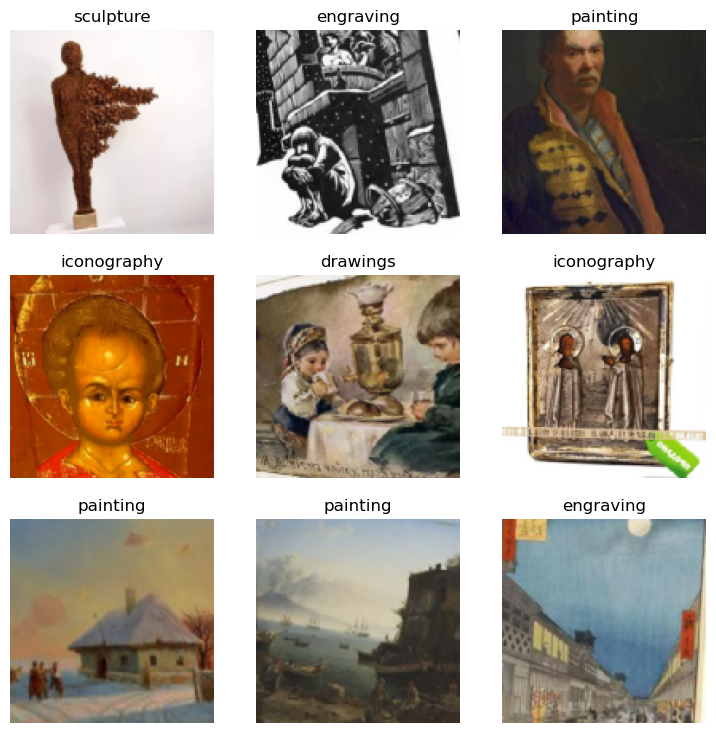

In [159]:
# Show an example batch of images
dls.show_batch()

# Model Specification, Training, Results Validation

Once our data is loaded in, our next step is to specify our model.

One key idea that I have taken away from fastai is the high effectiveness of using **transfer learning** for new machine learning tasks.

Transfer learning is a method of using pretrained models that were trained on one task as a starting point for training models on a new task. 

For computer vision tasks, fastai makes initializing a pretrained model simple through `vision_learner`--by default, the `pretrained` parameter is `True`. When we use a pretrained model, the last layer is replaced with a new linear layer with the same number of outputs as our new transfer learning problem (in this case 5 classes). However, this new layer is randomly initialized so we will need to make sure to tune our model to correctly predict the different artwork types.

To start, we will use the **resnet50** architecture and track the `accuracy` metric (percent of images predicted correctly). 

In [160]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

/home/yang/miniconda3/envs/fastai-learn/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yang/miniconda3/envs/fastai-learn/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Learning Rate Finder

For our model, we first need to select a good learning rate to start our training. Fastai implements a learning rate finder method `Learner.lr_find` based on Leslie Smith's paper called [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf).

Smith describes his approach as the following:

> There is a simple way to estimate reasonable minimum and maximum boundary values with one training run of the network for a few epochs. It is a “LR range test”; run your model for several epochs while letting the learning rate increase linearly between low and high LR values.

Essentially, we check our training losses as we grow our learning rate to get an idea of what learning rate performs well.

Fastai takes a slightly different approach: The model is test-trained with learning rates that grow exponentially from a low learning rate to a higher learning rate across a number of mini-batches. The process continues until we find a learning rate where the loss begins to diverge and increases significantly.

What this boils down to is that in the fastai version we don't necessarily need to run for multiple epochs to get an optimal learning rate as we are training for a set number of mini-batches.

Conveniently, `lr_find` gives us the loss vs. learning rate plot and also enables us to directly extract learning rates that could be optimal based off different *suggestion* functions. For example, we can use `steep` which gets the learning rate with the steepest slope. 

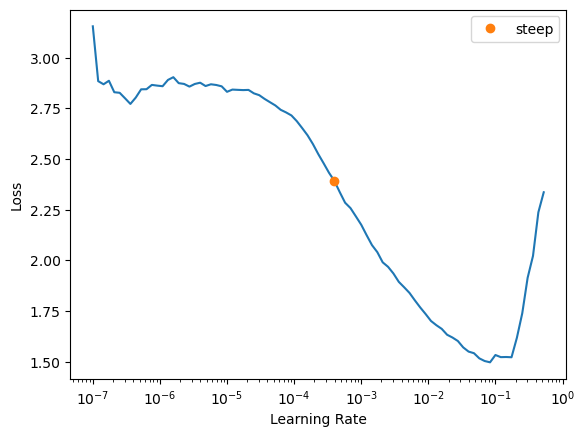

In [161]:
#| fig-cap: Log plot of loss vs. learning rate

lr_steep = learn.lr_find(suggest_funcs=steep)

## One-cycle Idea

We can now start training our model! Using the `fit_one_cycle` method we are actually training our model with what is called the **one-cycle policy**, an idea that again comes from Leslie Smith and changes our learning rate over the course of training. I won't be going into close detail on how the 1cycle policy is implemented in the scope of this article. 

At a high level, we are starting at some initial learning rate, linearly increasing our learning rate after every batch up to a maximum learning rate, and from the maximum learning rate down to some minimum learning rate several magnitudes lower than our initial learning rate. 

The idea behind this all is to warm up our training with a low learning rate and use the high learning rate to help find minimums in our loss function that are flatter, allowing the model to generalize better. 

During the last segment of training, the descending learning rates help the optimizer avoid skipping over a steeper loss within the flatter areas. This process allows our model to converge faster and consequently achieve better results with lower iterations than traditional training methods. Smith calls this occurrence **super-convergence.**

In [162]:
#| code-fold: true


def plot_example_cycle(x_min, x_max, y_min, y_max, padding):
    values = 100
    x = np.linspace(x_min, x_max, values + padding)

    y1 = np.linspace(y_min, y_max, values // 2, endpoint=False)
    y2 = np.linspace(y_max, y_min, values // 2, endpoint=False)
    padded_values = np.linspace(y_min, y_min * 1e-2, padding)

    y = np.concatenate((y1, y2, padded_values))

    plt.plot(x, y)
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

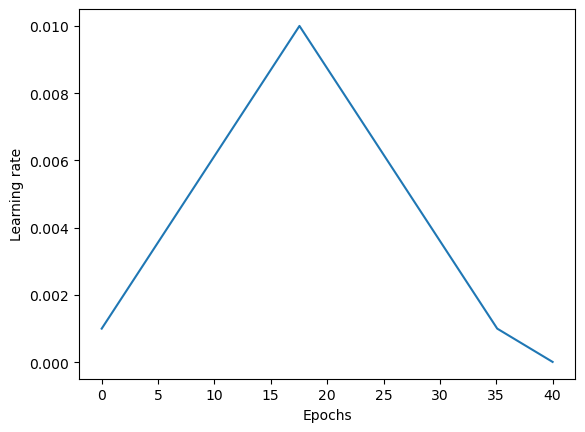

In [163]:
#| label: fig-1cycle-example
#| fig-cap: Example representation of a linear 1cycle learning rate schedule.

plot_example_cycle(0, 40, 0.001, 0.01, 15)

<!-- Now that I'm using fine_tune method this section needs a bit of revision -->
With transfer learning, our model has additional new layers that we can train for the problem we are trying to solve. At the start of training, we may not want to completely readjust the weights in the model's previously learned layers because they account for high-level details of the image like line and shape.

In a pretrained model, the previous trained layers start out **frozen**, meaning their weights aren't updated during training unless we unfreeze them. Later, we will unfreeze all the layers and use a range of learning rates to help adjust them slightly for our artwork classification.

Fastai recommends training the frozen pretrained model for a few epochs before training the full pretrained model. We'll start with 3 epochs frozen using the learning rate we found before and then train the full model for 10 epochs. We can get an idea of how our error rates changes across training from here. Our losses along with our metrics will be useful in determining if we've fitted a decent model or whether we are underfitting or overfitting.

In [164]:
learn.fit_one_cycle(3, lr_steep.steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.736585,0.392074,0.876295,00:08
1,0.424036,0.314158,0.897668,00:08
2,0.323496,0.301114,0.902850,00:08


Now we can unfreeze the layers and find a new learning rate to train on:

SuggestedLRs(valley=1.9054607491852948e-06)

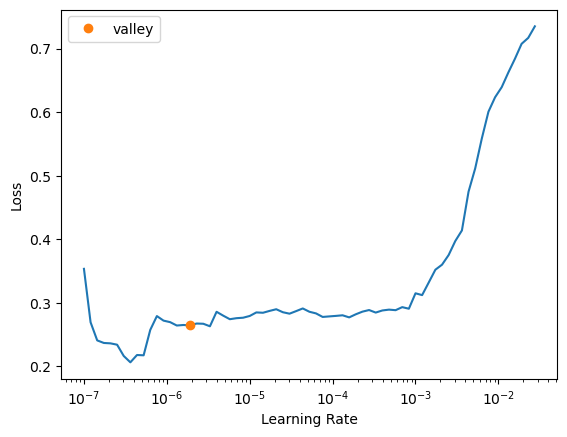

In [165]:
learn.unfreeze()
learn.lr_find()

In [166]:
learn.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.303461,0.285741,0.904145,00:10
1,0.287183,0.274196,0.912565,00:10
2,0.248374,0.275502,0.908679,00:10
3,0.230601,0.256986,0.916451,00:10
4,0.206843,0.242086,0.917098,00:10
5,0.198138,0.229480,0.919689,00:09
6,0.172902,0.233433,0.917746,00:10
7,0.165584,0.247205,0.917746,00:10
8,0.161742,0.228472,0.919041,00:10
9,0.156249,0.243762,0.917098,00:10


## Interpreting the Loss Curves, Further Training?

After training our model, we will see how our training and validation losses have changed over the course of our iteration / epochs using **loss curves**. Loss curves won't provide the entire story of our model but we'll have a broad picture of how our model performs over the selected dataset and batch size. @fig-loss-iterations shows the loss curves across the training iterations.

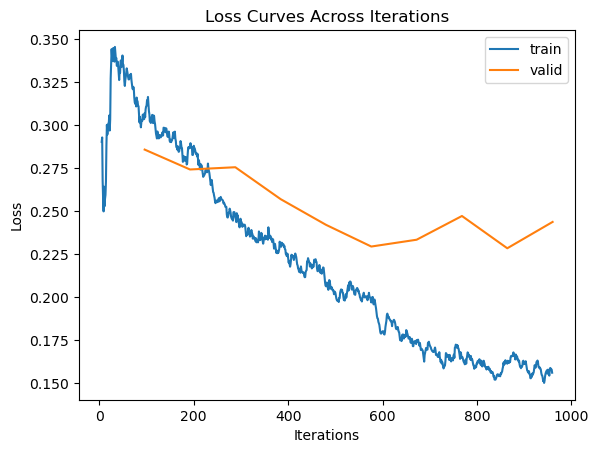

In [170]:
#| label: fig-loss-iterations
#| fig-cap: Loss curves across the model's training iterations

learn.recorder.plot_loss()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title('Loss Curves Across Iterations')
plt.show()

Initially, our validation loss starts out lower than our training loss but our training loss quickly converges as our training progresses.

We should note that we reach a point where our validation loss is higher than our training loss and stagnates a bit. The model is becoming overconfident in its predictions and we have to ask ourselves: are we **overfitting**? 

@fig-loss-epochs shows the loss curves across the training epochs in case we need to go back and retrain our model to a previous epoch.

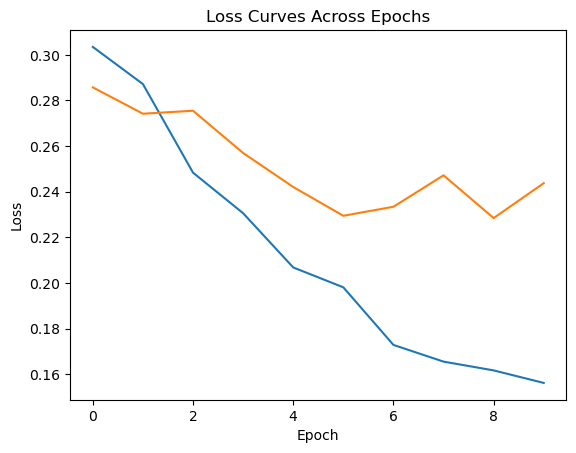

In [171]:
#| label: fig-loss-epochs
#| fig-cap: Loss curves across training epochs

train_loss = L(learn.recorder.values).itemgot(0)
valid_loss = L(learn.recorder.values).itemgot(1)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves Across Epochs')
plt.show()

## Overfitting

Overfitting occurs when we have trained for too long and the model begins to "memorize" the training data while failing to generalize well to new data.

When we look at our losses visually, we can see that there is an emerging gap between our training and validation loss and the latter seems to stagnate. How big of a gap is too big? It's hard to say because it depends on a variety of factors like the scale of the dataset. Rather, we should look for general stability in our validation loss throughout training. If our validation loss begins to increase significantly, then we might begin to worry that we are overfitting to our training data too much.

We could stop early, but with one-cycle training that may not be a good idea because we may not allow our learning rate to reach the small values that would benefit our training.

One key takeaway from fastai is that we should be checking to see if our performance metrics are getting significantly worse to decide if the model is overfitting. It's not enough to view the losses alone. 

@fig-accuracy-epochs shows the accuracy across the training epochs.

Highest accuracy during last run: 5


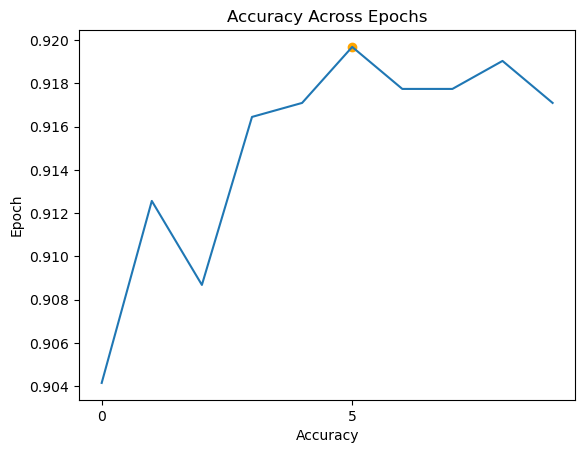

In [172]:
#| label: fig-accuracy-epochs
#| fig-cap: Accuracy across the training epochs

accuracy_metric = L(learn.recorder.values).itemgot(2)
highest_accuracy_epoch = np.argmax(accuracy_metric)
print(f'Highest accuracy during last run: {highest_accuracy_epoch}')

plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.title('Accuracy Across Epochs')
plt.xticks(np.arange(0, len(accuracy_metric) + 1, 5))

plt.plot(accuracy_metric)
plt.scatter(highest_accuracy_epoch, accuracy_metric[highest_accuracy_epoch], color='orange')
plt.show()

Our highest accuracy is at **epoch 5** but the accuracy appears to be flattening out towards the end. If we take into account both our validation loss and metric, then we aren't too concerned about overfitting. Fortunately, we do have a few options in the case of severe overfitting! We could introduce weight decay or even rerun our model with a lower number of epochs and adjust from there. In this case, we will add some weight decay using discriminative learning rates.

We should keep in mind that our performance metric is what ultimately matters in practice. 

As Jeremy Howard states: 

> "In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize."
>
> "Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice."

To really evaluate our model's performance, we would run our model on a representative test data set that it has never seen before. This will allow us to get a more honest assessment of how our model is doing and we don't want to report accuracy on our training model alone. Once we've decided on a model, we'll look at how we can use the images we didn't use for training as a test set.

In [173]:
#| warning: false
set_seed(1234, reproducible=True)

# Reinitialize our model to restart training
learn2 = vision_learner(dls, resnet50, metrics=accuracy, wd=0.1)

In [174]:
lr_steep = learn2.lr_find(suggest_funcs=steep, show_plot=False)

learn2.fit_one_cycle(3, lr_steep.steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.700870,0.393677,0.878238,00:08
1,0.397226,0.291531,0.904145,00:08
2,0.283082,0.267353,0.907383,00:08


SuggestedLRs(valley=2.511886486900039e-05)

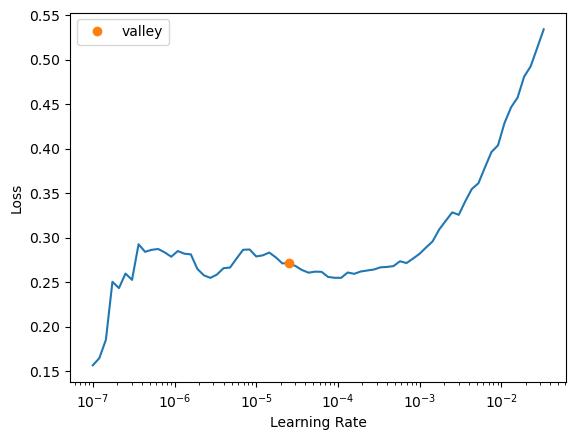

In [175]:
learn2.unfreeze()
learn2.lr_find()

In [176]:
learn2.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.244180,0.268016,0.908031,00:10
1,0.230895,0.245873,0.914508,00:10
2,0.220922,0.250578,0.913212,00:10
3,0.194323,0.241496,0.919041,00:10
4,0.166755,0.239293,0.920337,00:10
5,0.157978,0.234968,0.919689,00:10
6,0.139419,0.236333,0.919041,00:09
7,0.132599,0.227974,0.925518,00:10
8,0.127297,0.230230,0.924870,00:10
9,0.123424,0.223977,0.926813,00:10


Our accuracy is about the same, but our loss curves in @fig-loss-iterations-wd are a bit smoother and our validation loss in particular shows a smoother, more consistent decreasing trend. For now, we'll move forward with this model. 

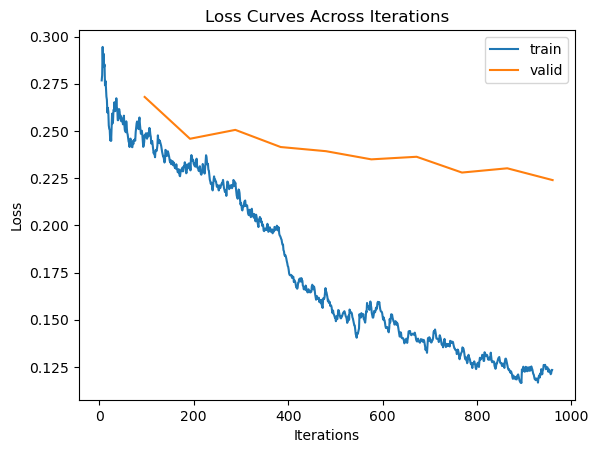

In [177]:
#| label: fig-loss-iterations-wd
#| fig-cap: Loss curves across the model's training iterations

learn2.recorder.plot_loss()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title('Loss Curves Across Iterations')
plt.show()

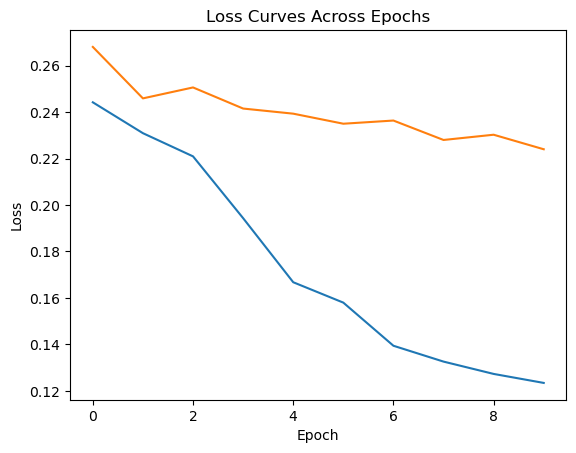

In [178]:
#| label: fig-loss-epochs-wd
#| fig-cap: Loss curves across training epochs

train_loss = L(learn2.recorder.values).itemgot(0)
valid_loss = L(learn2.recorder.values).itemgot(1)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves Across Epochs')
plt.show()

Highest accuracy during last run: 9


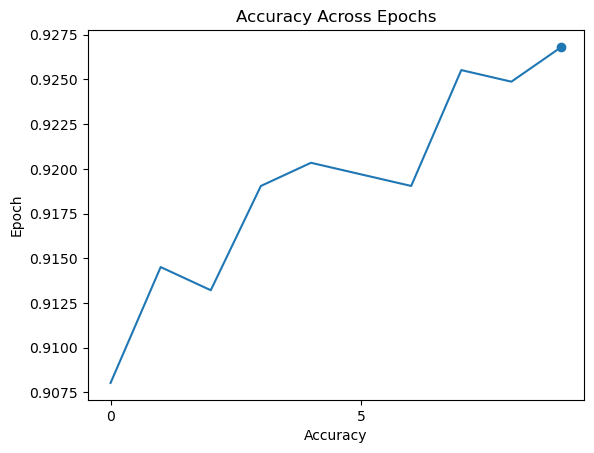

In [179]:
#| label: fig-accuracy-epochs-wd
#| fig-cap: Accuracy across the training epochs

accuracy_metric = L(learn2.recorder.values).itemgot(2)
highest_accuracy_epoch = np.argmax(accuracy_metric)
print(f'Highest accuracy during last run: {highest_accuracy_epoch}')

plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.title('Accuracy Across Epochs')
plt.xticks(np.arange(0, len(accuracy_metric) + 1, 5))

plt.plot(accuracy_metric)
plt.scatter(highest_accuracy_epoch, accuracy_metric[highest_accuracy_epoch])
plt.show()

Our accuracy metric seems to be increasing overall. The weight decay model is definitely learning patterns about the data and seems like it could potentially generalize well to similar data.

We can use a confusion matrix to see the number of correctly classified and misclassified images on our training set. @fig-confusion-matrix displays the confusion matrix for the model we just fine-tuned.

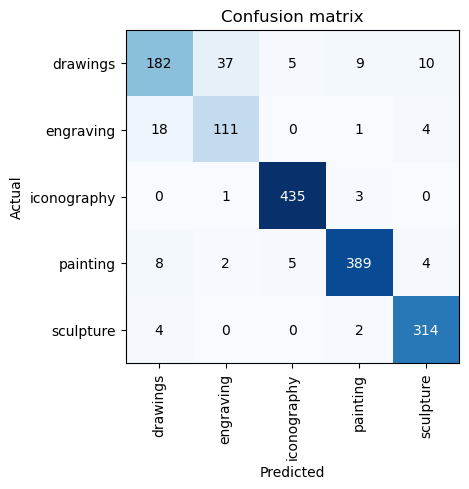

In [180]:
#| label: fig-confusion-matrix
#| fig-cap: Confusion matrix on the training set
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

We can also display a report with common classification metrics like precision, recall, and the F1-score. For this project, we are mainly focused on the F1-score.

The weighted F1-score is the the mean of all the class F1 scores while taking into account the number of occurrences in each class. In general, we are aiming for a balance between precision and recall on a scale between 0 and 1. Our model achieved a weighted F1-score of **0.930** on the training set.

In [181]:
interp.print_classification_report()

              precision    recall  f1-score   support

    drawings       0.86      0.75      0.80       243
   engraving       0.74      0.83      0.78       134
 iconography       0.98      0.99      0.98       439
    painting       0.96      0.95      0.96       408
   sculpture       0.95      0.98      0.96       320

    accuracy                           0.93      1544
   macro avg       0.90      0.90      0.90      1544
weighted avg       0.93      0.93      0.93      1544



@fig-top-losses shows the top 10 losses of training images predicted by our model. We can use this to get a visual idea of what kinds of images our model might be misclassifying. 

In particular, from both the classification report and the top losses our model seems to misclassify engravings and drawings more than other types of art. Maybe not all images are standardized and there are definitely tough cases where the line between painting, drawing, and iconography are blurry.

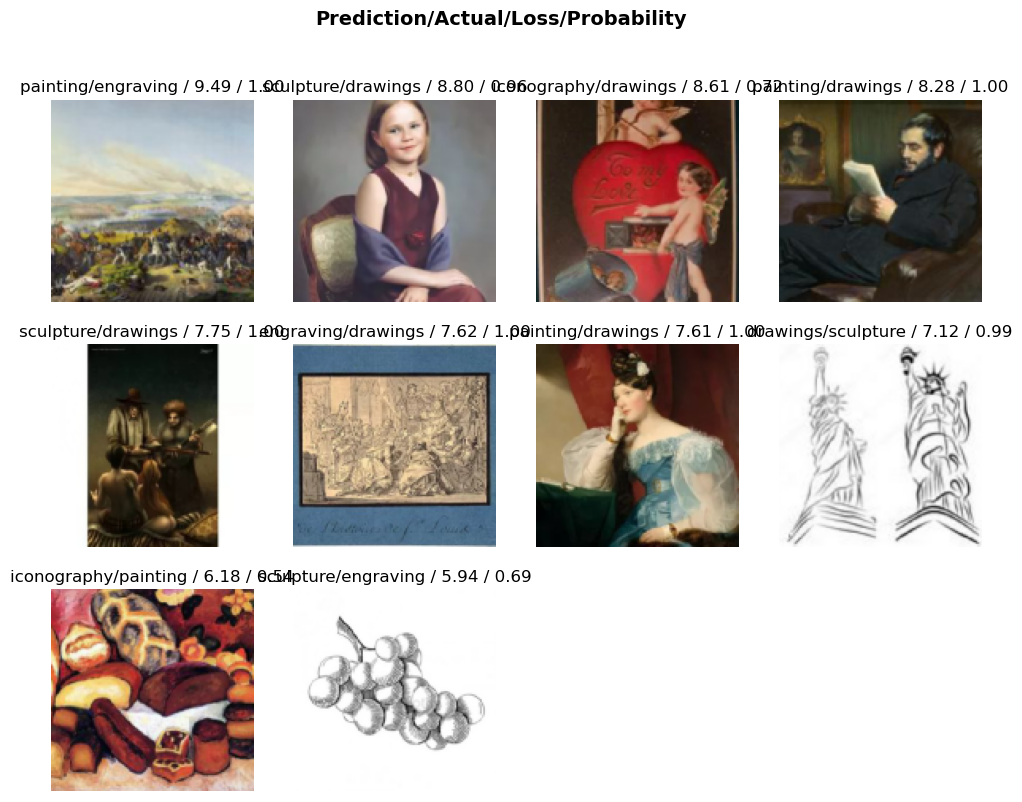

In [182]:
#| label: fig-top-losses
#| fig-cap: Top 10 losses of images in the training set
interp.plot_top_losses(10)

It's fascinating that we are able to classify images at all with these results with a bit of conceptual understanding and a few lines of code! However, we still need to evaluate on the test set for reporting purposes.

# Prediction / Inference

The last thing I want to cover is how we can use our newly trained model to make predictions on new artwork images. We first export our model:

In [184]:
# Save model into models/
model_path = Path('models')
learn2.export(model_path / 'artwork.pkl')

In [185]:
# Load model and display the unique classes that can be predicted by the model
artwork_model = load_learner(model_path / 'artwork.pkl')
artwork_model.dls.vocab

['drawings', 'engraving', 'iconography', 'painting', 'sculpture']

After retrieving our model, we need to supply our test images as a dataloader. Call the `test_dl` method on our dataloaders object will allow us to apply all the transformations we used in training and instantly format the test images to be input to the model

In [186]:
test_set_images = get_image_files(data_path / 'validation_set')
test_dl = dls.test_dl(test_set_images, with_labels=True)

In [187]:
preds, targs = artwork_model.get_preds(dl=test_dl)
preds, targs

(tensor([[1.7097e-07, 1.4081e-07, 1.0000e+00, 2.4616e-09, 8.9511e-12],
         [2.1447e-07, 2.5128e-06, 1.0000e+00, 2.4878e-07, 2.5384e-08],
         [7.3848e-06, 4.2883e-07, 9.9999e-01, 3.3878e-07, 1.7286e-08],
         ...,
         [9.9994e-01, 1.3714e-05, 6.5628e-08, 1.0309e-05, 3.7829e-05],
         [5.5740e-01, 5.4812e-02, 5.7539e-02, 2.5999e-01, 7.0268e-02],
         [9.9638e-01, 3.6179e-03, 1.0414e-07, 1.3658e-06, 1.2304e-06]]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [188]:
# Get a list of individual probabilities for each class
# list(zip(artwork_model.dls.vocab, artwork_model.predict(img_inf)[2] * 100))
pred_labels = preds.argmax(dim=1)
(pred_labels == targs).float().mean()

tensor(0.9182)

In [189]:
print(classification_report(targs, pred_labels, target_names=artwork_model.dls.vocab, digits=4))

              precision    recall  f1-score   support

    drawings     0.7686    0.7623    0.7654       122
   engraving     0.7867    0.7024    0.7421        84
 iconography     0.9622    0.9913    0.9765       231
    painting     0.9558    0.9474    0.9515       228
   sculpture     0.9643    0.9895    0.9767       191

    accuracy                         0.9182       856
   macro avg     0.8875    0.8786    0.8825       856
weighted avg     0.9161    0.9182    0.9168       856



On our test set, the model achieved an overall accuracy of **91.8%** and a weighted F1-score of **0.917**. Without going into too many optimizations, we were able to find a model that performed remarkably on our artwork data. We applied transfer learning, learned how to determine learning rates with the learning rate finder, and used one-cycle to train a deep learning model with a funny eye for art! Along the way, we also explored important tools for diagnosing our model like loss curves and classification reports. 

Although it's outside the scope of this article, we could now take the next step and retrain our model with the full data for deployment. We would be able to evaluate the model on new data that users are feeding to the model!

# Further Steps / Moving Forward

We covered a lot of concepts! Deep learning and data science as a whole is an art form. For every step in the model development process there are always more design choices and optimizations we could have made. I'm eager to explore every single concept I've been learning about, but there is too much to cover in a single article. I chose to focus on the concepts that I think will help readers understand essential elements of fastai and deep learning. 

Here are a few deep learning concepts (computer vision and general topics) that I would love to cover in future posts:

-   Multi-label classification
-   Data augmentation: Progressive resizing, mixup, cutout
-   Convolution neural networks in detail

Happy learning!